In [1]:
import numpy as np
from matplotlib import pyplot as plt
from skimage.transform import rescale, resize, radon, iradon
from skimage.filters import gaussian
import scipy
from scipy.interpolate import CubicSpline
from scipy.optimize import root


In [2]:
def plot(plots, figsize=(10,10)):
    plt.figure(figsize=figsize)
    z = zip(plots)
    a = len(plots)
    b = list(range(a))
    for i in range(a):
        n = next(z)
        plt.subplot(int((a/2)*100+21+b[i]))
        #snr = entropy(n[0],rectangle(n[0].shape[0],n[0].shape[1])) #np.mean(n[0])/np.std(n[0])
        #plt.title('SNR = ' + str(snr)[0:5])
        plt.imshow(n[0])
    plt.show()

def threshold_plot(plot, amount):
    plot = plot - (np.mean(plot)-np.std(plot)/amount)
    plot = np.asarray([0 if i <0 else i for i in plot])
    return plot

def add_noise(array, mean, std, multiplier):
    noise = np.random.normal(mean,std ,array.shape)*multiplier
    array = array+noise-np.min(noise)
    array = np.array(((array-np.min(array))/np.max(array))*(2**16), dtype=np.uint16)
    return array

# Initialize Phantom

In [3]:
imshape = 512
im = (imshape,imshape)
offset = 0#int(imshape/10)+300
posa = int(imshape/2)-int(512/2)+offset
posb = int(imshape/2)+int(512/2)+offset
#Load Shepp Logan Phantom
slp = np.asarray(plt.imread('./pictures/Shepp-Logan_Phantom.tif')[:,:], dtype= float)

#Create space for offsetting phantom
phantom=np.zeros(im)
'''
if posa > phantom.shape[0] or posb>phantom.shape[1]:
    phantom = slp[len(slp)-offset:len(slp)+offset,len(slp)-offset:len(slp)+offset]
else:
    phantom[posa:posb,posa:posb] = slp
'''
phantom = slp[int(512/2)-int(imshape/2):int(512/2)+int(imshape/2),int(512/2)-int(imshape/2):int(512/2)+int(imshape/2)]
number_angles = 500

#create stack
phantom_stack = np.zeros(phantom.shape)
for i in range(number_angles):
    phantom_stack = phantom_stack + add_noise(phantom, np.mean(phantom),np.std(phantom), 50)

phantom_noise = add_noise(phantom, np.mean(phantom),np.std(phantom), 50)
    


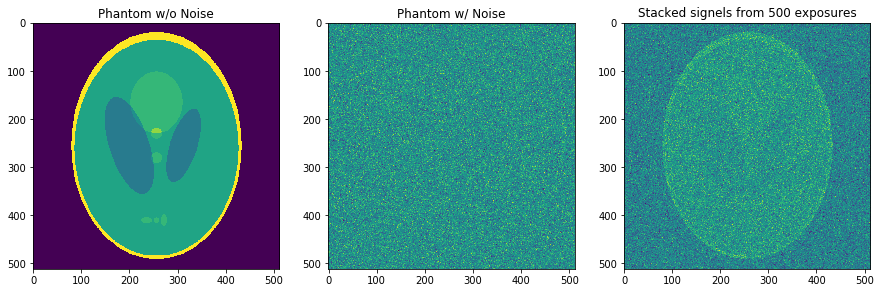

In [4]:
plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(phantom)
plt.title('Phantom w/o Noise')
plt.subplot(132)
plt.imshow(phantom_noise)
plt.title('Phantom w/ Noise')
plt.subplot(133)
plt.imshow(phantom_stack)
plt.title('Stacked signels from ' + str(number_angles) + ' exposures')
plt.show()

# Generate Sinogram

In [5]:
#Generate sinogram
Circle = True
theta = np.linspace(0., 360, number_angles, endpoint=False)
sinogram = radon(phantom, theta=theta, circle=Circle)

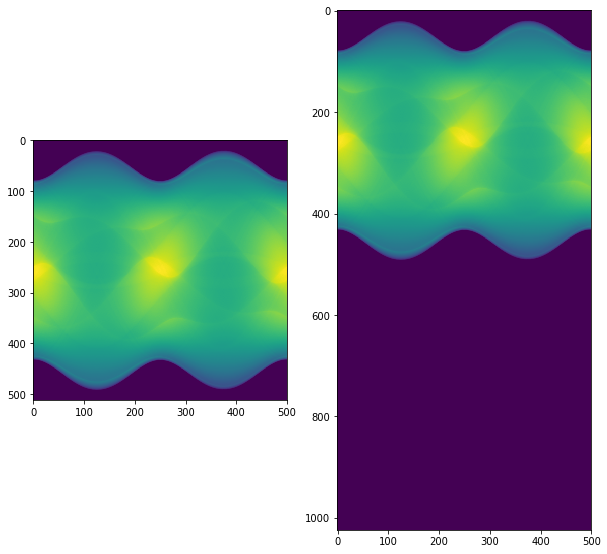

In [6]:
#shift sinogram so rotation center is off of image center and add noise
sinogram_shift_noiseless = np.zeros((sinogram.shape[0]*2,sinogram.shape[1]))
sinogram_shift_noiseless[0:sinogram.shape[0],:] = sinogram

plot((sinogram, sinogram_shift_noiseless))

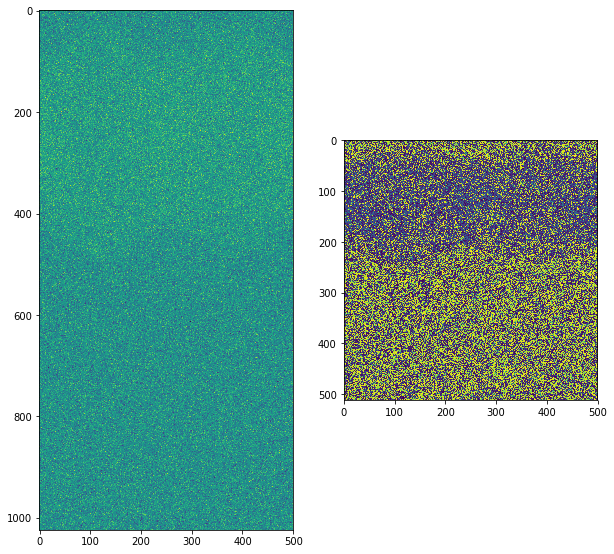

In [7]:
# add noise
noise = 5
sinogram_shift = add_noise(sinogram_shift_noiseless,np.mean(sinogram),np.std(sinogram), noise)

#Mess around with increasing dynamic range
#sinogram_resized = resize(sinogram_shift, (int(sinogram_shift.shape[0] / 2), int(sinogram_shift.shape[1] / 1)), clip=False)

resize_factor = 2
sinogram_resized = np.zeros((int(sinogram_shift.shape[0]/resize_factor),int(sinogram_shift.shape[1])))
for i in range(sinogram_resized.shape[0]):
    sinogram_resized[i,:] = sinogram_shift[i*resize_factor,:]+sinogram_shift[i*resize_factor+1,:]
    

plot((sinogram_shift, sinogram_resized))
snr = np.mean(sinogram_shift)/np.std(sinogram_shift)

# Find Center of Mass with strict thresholding

4.894450153897024


/home/everett/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


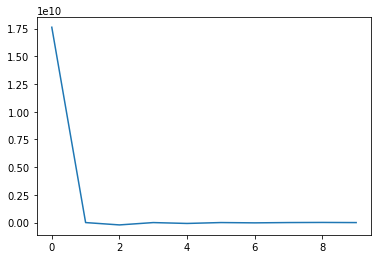

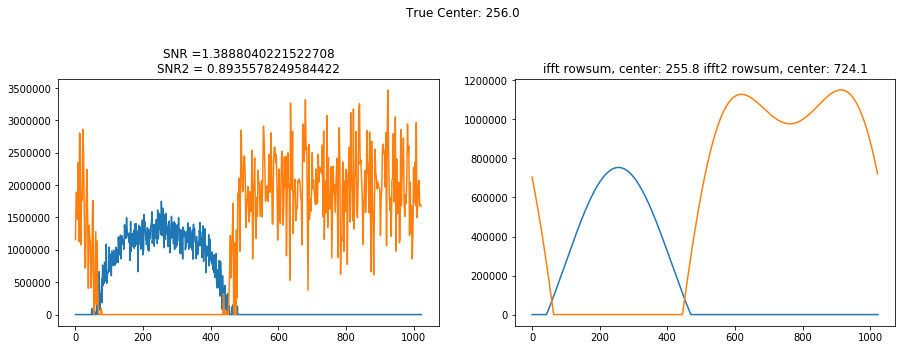

In [8]:
#sum projections from sinogram to find rotation center (sym center)
print(snr)
threshold_amount = snr*2 #increase threshold to remove off-feature noise
fft_cutoff = 3#decrease fft cutoff to reduce high frequencies

rowsum = threshold_plot(np.sum(sinogram_shift, axis=1),threshold_amount)
var = threshold_plot(np.std(sinogram_shift, axis=1),threshold_amount)
mean = threshold_plot(np.mean(sinogram_shift, axis=1),threshold_amount)


#sum for interpolated image
rowsum2 = threshold_plot(np.sum(sinogram_resized, axis=1),threshold_amount)
var2 = threshold_plot(np.std(sinogram_resized, axis=1),threshold_amount)
mean2 = threshold_plot(np.mean(sinogram_resized, axis=1),threshold_amount)

#fft for row sum
fft = np.fft.fft(np.sum(sinogram_shift, axis=1))
plt.plot(fft[0:10])
plt.show()
fft[fft_cutoff:]=0+0j
ifft = threshold_plot(np.fft.ifft(fft),threshold_amount)

fft2 = np.fft.fft(np.sum(sinogram_resized, axis=1))
fft2[fft_cutoff:]=0
ifft2 = threshold_plot(np.fft.ifft(fft2),threshold_amount)
'''
#fft for variance
fftv = np.fft.fft(np.std(sinogram_shift, axis=1))
fftv[fft_cutoff:]=0
ifftv = threshold_plot(np.fft.ifft(fftv),threshold_amount)

fftv2 = np.fft.fft(np.std(sinogram_resized, axis=1))
fftv2[fft_cutoff:]=0
ifftv2 = threshold_plot(np.fft.ifft(fftv2),threshold_amount)
'''
#Center of Mass (COM) guess at root
COM = scipy.ndimage.measurements.center_of_mass(np.real(ifft))[0]/len(ifft)*sinogram_shift.shape[0]
COM2 = scipy.ndimage.measurements.center_of_mass(np.real(ifft2))[0]/len(ifft2)*sinogram_resized.shape[0]


r = np.arange(0,sinogram_shift.shape[0],resize_factor)#sinogram_resized.shape[0])

if Circle == False:
    true_center = sinogram.shape[0]/2
else:
    true_center = imshape/2

plt.figure(figsize=(15,10))
plt.suptitle('True Center: ' + str(true_center))
plt.subplot(222)
plt.title('ifft rowsum, center: ' + str(COM)[0:5]+' ifft2 rowsum, center: '+str(COM2*resize_factor)[0:5])
plt.plot(ifft)
plt.plot(r,np.real(ifft2))

plt.subplot(221)
plt.title('SNR ='+ str(np.std(rowsum)/np.mean(rowsum)) + '\nSNR2 = '+ str(np.std(rowsum2)/np.mean(rowsum2)))
plt.plot(rowsum)
plt.plot(r,rowsum2)

np.save('rowsum',ifft)

'''
plt.subplot(223)
plt.title('SNR ='+ str(np.std(mean)/np.mean(mean)) + ' SNR2 = '+ str(np.std(mean)/np.mean(mean)))
plt.plot(var)
plt.plot(r, var2)

plt.subplot(224)
plt.title('ifft var')
plt.plot(np.real(ifftv))
plt.plot(r, np.real(ifftv2))
'''
plt.show()

# All COM


In [9]:
#Calculate Center of Mass

#threshold the plots
'''
rowsum = threshold_plot(np.sum(sinogram_shift, axis=1))
var = threshold_plot(np.std(sinogram_shift, axis=1))
mean = threshold_plot(np.mean(sinogram_shift, axis=1))

rowsum2 = threshold_plot(np.sum(sinogram_resized, axis=1))
var2 = threshold_plot(np.std(sinogram_resized, axis=1))
mean2 = threshold_plot(np.mean(sinogram_resized, axis=1))
'''
print('True Center ', true_center)
#print('var ', scipy.ndimage.measurements.center_of_mass(var)[0]/len(var)*sinogram_shift.shape[0])
#print('var2 ', scipy.ndimage.measurements.center_of_mass(var2)[0]/len(var2)*sinogram_shift.shape[0])
print('rowsum ', scipy.ndimage.measurements.center_of_mass(rowsum)[0]/len(rowsum)*sinogram_shift.shape[0])
print('rowsum2 ', scipy.ndimage.measurements.center_of_mass(rowsum2)[0]/len(rowsum2)*sinogram_shift.shape[0])
print('ifft ', scipy.ndimage.measurements.center_of_mass(np.real(ifft))[0]/len(ifft)*sinogram_shift.shape[0])
print('ifft2 ', scipy.ndimage.measurements.center_of_mass(np.real(ifft2))[0]/len(ifft2)*sinogram_shift.shape[0])

True Center  128.0
rowsum  385.1051314537362
rowsum2  127.98651866668826
ifft  384.3550204262782
ifft2  132.59348238654061


# Max value 
Works well when sample is sufficiently on-center but detector is off-center.

Works poorly when sample is far off-center.

In [10]:
for i in range(len(ifft2)):
    if ifft2[i]==np.max(ifft2):
        ifft_max = i
        print(i*2)
    else:
        pass

64


# Interpolate function to find Root with COM as initial guess

4045899800.529544 
 4827964.591598997


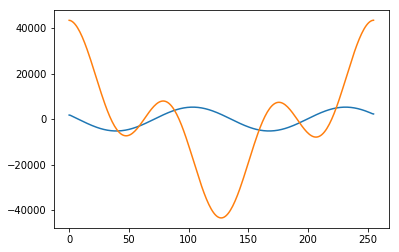

"\nprint(r0,'\n')\n\nplt.plot((np.real(ifft)-np.min(np.real(ifft)))*3000/(1*10**6))\nplt.plot(f2(x))\nplt.title(r0['x'][0])\nplt.show()\n\n\n#find width of sinogram\n#x = np.linspace(0,len(np.gradient(np.real(ifft))),len(np.gradient(np.real(ifft))))\nf3 = CubicSpline(x, np.gradient(np.real(ifft)), bc_type='clamped')\nr12 =root(f2,[r0['x'][0]*.2, r0['x'][0]*2])\nprint(r12)\n"

In [11]:
#Rethreshold to lower level and include more data
threshold_amount = None#increase threshold to remove off-feature noise
fft_cutoff = None #decrease fft cutoff to reduce high frequencies
fft_threshold = None
r0_even = []
r0_odd = []

#Use COM to guess root
rowsum_grad = np.sum(sinogram_resized, axis=1)

#fft for row sum
fft = np.fft.fft(rowsum_grad) #np.sum(sinogram_shift, axis=1))
fft_even = np.ones(fft.shape)*0+0j
fft_odd = np.ones(fft.shape)*0+0j
for i in range(2):
    fft_even[i*2]=fft[i*2]
    fft_odd[i*2+1]=fft[i*2+1]
    
#fft_even[200:]=0+0j
#fft_odd[200:]=0+0j

#Interpolate function and guess root
ifft_even = np.fft.ifft(fft_even)#threshold_plot(np.fft.ifftshift((np.fft.ifft(fft))),fft_threshold)
ifft_odd = np.fft.ifft(fft_odd)
x = np.arange(0,len(np.gradient(np.real(ifft_even)))*2,2)
f2_even = CubicSpline(x, np.gradient(np.real(ifft_even)))
f2_odd = CubicSpline(x, np.gradient(np.real(ifft_odd)))
r0_even = root(f2_even,COM)['x'][0]
r0_odd = root(f2_odd,COM)['x'][0]
'''
for i in range(10):
    fft_even[:] = fft[:]
    fft_even[i:]=0+0j    
    fft_odd[:] = fft[:]
    fft_odd[i*2+1:]=0+0j
    ifft_even = np.fft.ifft(fft_even)#threshold_plot(np.fft.ifftshift((np.fft.ifft(fft))),fft_threshold)
    ifft_odd = np.fft.ifft(fft_odd)
    
    
    #Interpolate function and guess root
    x = np.arange(0,len(np.gradient(np.real(ifft_even)))*2,2)
    f2_even = CubicSpline(x, np.gradient(np.real(ifft_even)))
    f2_odd = CubicSpline(x, np.gradient(np.real(ifft_odd)))
    r0_even.append(root(f2_even,COM)['x'][0])
    r0_odd.append(root(f2_odd,COM)['x'][0])
'''    
#print(r0_even, r0_odd, '\n\n')
print(np.sum(np.real(fft_even)), '\n', np.sum(np.real(fft_odd)))
#print('Even std: ', np.std(r0_even), ' mean: ', np.mean(r0_even))
#print('Odd std: ', np.std(r0_odd), ' mean: ', np.mean(r0_odd))

plt.plot(f2_even(x))
plt.plot(f2_odd(x))
plt.show()

'''
print(r0,'\n')

plt.plot((np.real(ifft)-np.min(np.real(ifft)))*3000/(1*10**6))
plt.plot(f2(x))
plt.title(r0['x'][0])
plt.show()


#find width of sinogram
#x = np.linspace(0,len(np.gradient(np.real(ifft))),len(np.gradient(np.real(ifft))))
f3 = CubicSpline(x, np.gradient(np.real(ifft)), bc_type='clamped')
r12 =root(f2,[r0['x'][0]*.2, r0['x'][0]*2])
print(r12)
'''

In [12]:
center_of_rotation = r0['x'][0]
sino_range = (int(np.floor(r12['x'][0])),int(np.ceil(r12['x'][1])))
print(sino_range)
adj_sino = sinogram_shift[sino_range[0]:sino_range[1],:]


rowsum = np.sum(adj_sino, axis=1)
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(adj_sino)
plt.subplot(122)
plt.plot(rowsum)
plt.show()

NameError: name 'r0' is not defined